# Plotting of Evaluation Results

You need to run `aggregator.py 0 49` first. Specify which results to aggregate in `settings.py`.
`0 49` means aggregate run 0-49; adjust as needed.

Goal: Show that the algorithms achieve good results in terms of successful flows and delay.
Compare the different algorithms. Also differnt capacities. Focus on DFN network (58 nodes) and large GTS CE (149 nodes).

Seems like SPR1 is just worse than SPR2. I might drop it from the paper.

## Successful flows

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

result_dir = 'transformed_0-49'
config = 'hc'
network = 'dfn_58.graphml'
df = pd.read_csv(f'{result_dir}/{config}/{network}/flow/ci-t-metrics.csv',
                 names=['Ingress %', 'Value', 'Metric', 'Algorithm'])
df.head()

,Ingress %,Value,Metric,Algorithm
0,0.10,1340,total_flows,gpasp
1,0.10,1298,successful_flows,gpasp
2,0.10,0,dropped_flows,gpasp
3,0.10,42,in_network_flows,gpasp
4,0.15,1755,total_flows,gpasp


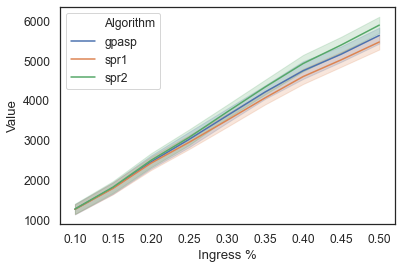

In [54]:
# plot successful flows with seaborn (needs long format)
df_successful = df[df['Metric'] == 'successful_flows']
sns.lineplot(df_successful['Ingress %'], df_successful['Value'], hue=df_successful['Algorithm'])

In [55]:
def long_to_wide_flows(df, alg):
    """Convert the long df to wide layout. Extract data for specified algorithm. Calculate total, % successful flows."""
    # long to wide
    df_alg = df[df['Algorithm'] == alg]
    df_wide = df_alg[df_alg['Metric'] == 'successful_flows'][['Ingress %', 'Value']]
    df_wide.rename(columns={'Value': 'Successful'}, inplace=True)
    # extract dropped flows
    df_tmp = df_alg[df_alg['Metric'] == 'dropped_flows'][['Ingress %', 'Value']]
    df_tmp.rename(columns={'Value': 'Dropped'}, inplace=True)
    df_wide = pd.merge(df_wide, df_tmp, on='Ingress %')
    # extract in-network flows
    df_tmp = df_alg[df_alg['Metric'] == 'in_network_flows'][['Ingress %', 'Value']]
    df_tmp.rename(columns={'Value': 'In-network'}, inplace=True)
    df_wide = pd.merge(df_wide, df_tmp, on='Ingress %')
    
    # calc total and % succesful flows
    df_wide['Total'] = df_wide['Successful'] + df_wide['Dropped'] + df_wide['In-network']
    df_wide['% Successful'] = df_wide['Successful'] / df_wide['Total']
    return df_wide
    
df_gpasp = long_to_wide_flows(df, 'gpasp')
df_spr1 = long_to_wide_flows(df, 'spr1')
df_spr2 = long_to_wide_flows(df, 'spr2')
df_gpasp.head()

,Ingress %,Successful,Dropped,In-network,Total,% Successful
0,0.1,1298,0,42,1340,0.968657
1,0.1,1298,0,47,1345,0.965056
2,0.1,1298,0,85,1383,0.938539
3,0.1,1298,0,65,1363,0.952311
4,0.1,1298,0,54,1352,0.960059


In [56]:
# random results (1 experiment)
df = pd.read_csv(f'transformed_rand_55/{config}/{network}/flow/t-metrics.csv',
                 names=['Ingress %', 'Value', 'Metric', 'Algorithm'])
df_rand = long_to_wide_flows(df, 'random')
df_rand.head()

,Ingress %,Successful,Dropped,In-network,Total,% Successful
0,0.1,1132.0,0.0,73.0,1205.0,0.939419
1,0.2,1498.0,0.0,99.0,1597.0,0.938009
2,0.3,2850.0,16.0,247.0,3113.0,0.915516
3,0.4,3781.0,20.0,348.0,4149.0,0.911304
4,0.5,5281.0,129.0,576.0,5986.0,0.882225


In [57]:
def df_mean_std(df, group_by=['Ingress %']):
    """Return 2 new dfs with 1) average and 2) std values"""
    df_mean = df.groupby(group_by).mean().reset_index()
    df_std = df.groupby(group_by).std().reset_index()
    return df_mean, df_std

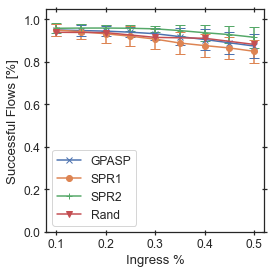

In [58]:
def plot_successful(dfs, labels, markers):
    """Plot % successful flows for the different algorithms"""
    assert len(dfs) == len(labels) == len(markers)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white')
    
    for i in range(len(dfs)):
        df_mean, df_std = df_mean_std(dfs[i])
        ax.errorbar(df_mean['Ingress %'], df_mean['% Successful'], yerr=df_std['% Successful'], capsize=5,
                    label=labels[i], marker=markers[i])
        
    ax.set_xlabel('Ingress %')
    ax.set_ylabel('Successful Flows [%]')
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    
    # remove error bars from legend: https://stackoverflow.com/a/15551976/2745116
    # get handles
    handles, labels = ax.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    ax.legend(handles, labels, numpoints=1)
    # ax.legend()
    
    # save
    plt.tight_layout()
    fig.savefig(f'plots/{network}_{config}_flows.pdf')
    
# plot_successful(dfs=[df_gpasp, df_spr1, df_spr2], labels=['GPASP', 'SPR1', 'SPR2'], 
#                 markers=['x', 'o', '+'])
plot_successful(dfs=[df_gpasp, df_spr1, df_spr2, df_rand], labels=['GPASP', 'SPR1', 'SPR2', 'Rand'], 
                markers=['x', 'o', '+', 'v'])
# how is random better than greedy??

## End-to-end delay

In [59]:
df = pd.read_csv(f'transformed_0-49/{config}/{network}/delay/ci-t-metrics.csv',
                 names=['Ingress %', 'Value', 'Metric', 'Algorithm'])
# filter e2e delay
df = df[df['Metric'] == 'avg_end2end_delay_of_processed_flows']
df.head()

,Ingress %,Value,Metric,Algorithm
2,0.10,35.441791,avg_end2end_delay_of_processed_flows,gpasp
5,0.15,33.621936,avg_end2end_delay_of_processed_flows,gpasp
8,0.20,34.690411,avg_end2end_delay_of_processed_flows,gpasp
11,0.25,36.561551,avg_end2end_delay_of_processed_flows,gpasp
14,0.30,41.018403,avg_end2end_delay_of_processed_flows,gpasp


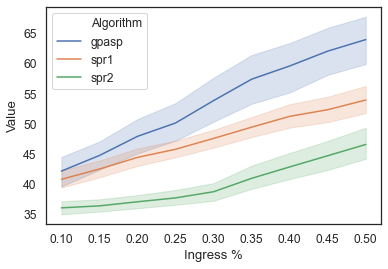

In [60]:
# plot e2e with seaborn (needs long format)
sns.lineplot(df['Ingress %'], df['Value'], hue=df['Algorithm'])

In [61]:
df_gpasp = df[df['Algorithm'] == 'gpasp']
df_spr1 = df[df['Algorithm'] == 'spr1']
df_spr2 = df[df['Algorithm'] == 'spr2']
df_gpasp.head()

,Ingress %,Value,Metric,Algorithm
2,0.10,35.441791,avg_end2end_delay_of_processed_flows,gpasp
5,0.15,33.621936,avg_end2end_delay_of_processed_flows,gpasp
8,0.20,34.690411,avg_end2end_delay_of_processed_flows,gpasp
11,0.25,36.561551,avg_end2end_delay_of_processed_flows,gpasp
14,0.30,41.018403,avg_end2end_delay_of_processed_flows,gpasp


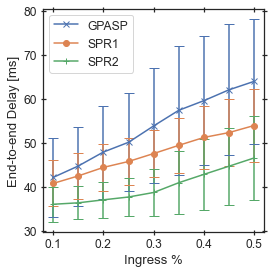

In [62]:
def plot_delay(dfs, labels, markers):
    """Plot % successful flows for the different algorithms"""
    assert len(dfs) == len(labels) == len(markers)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white')
    
    for i in range(len(dfs)):
        df_mean, df_std = df_mean_std(dfs[i])
        ax.errorbar(df_mean['Ingress %'], df_mean['Value'], yerr=df_std['Value'], capsize=5,
                    label=labels[i], marker=markers[i])
        
    ax.set_xlabel('Ingress %')
    ax.set_ylabel('End-to-end Delay [ms]')
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    
    # remove error bars from legend: https://stackoverflow.com/a/15551976/2745116
    # get handles
    handles, labels = ax.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # use them in the legend
    ax.legend(handles, labels, numpoints=1)
    # ax.legend()
    
    # save
    plt.tight_layout()
    fig.savefig(f'plots/{network}_{config}_delay.pdf')
    
plot_delay(dfs=[df_gpasp, df_spr1, df_spr2], labels=['GPASP', 'SPR1', 'SPR2'], markers=['x', 'o', '+'])



## Low-link scenario

In [63]:
def read_process_flow_results(result_dir, config, network):
    """Read, process results, return flow result dfs per algo"""
    df = pd.read_csv(f'{result_dir}/{config}/{network}/flow/ci-t-metrics.csv',
                     names=['Ingress %', 'Value', 'Metric', 'Algorithm'])
    algo_dfs = []
    for algo in df['Algorithm'].unique():
        algo_dfs.append(long_to_wide_flows(df, algo))

    return algo_dfs

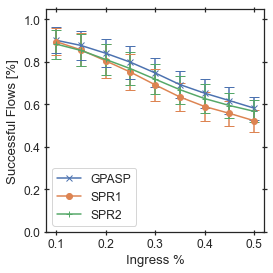

In [64]:
config = 'llc'
algo_dfs = read_process_flow_results(result_dir, config, network)

plot_successful(dfs=algo_dfs, labels=['GPASP', 'SPR1', 'SPR2'], 
                markers=['x', 'o', '+'])

In [68]:
def read_process_delay_results(result_dir, config, network):
    """Read, process delay results and return dfs per algo"""
    df = pd.read_csv(f'{result_dir}/{config}/{network}/delay/ci-t-metrics.csv',
                     names=['Ingress %', 'Value', 'Metric', 'Algorithm'])
    # filter e2e delay
    df = df[df['Metric'] == 'avg_end2end_delay_of_processed_flows']
    
    algo_dfs = []
    for algo in df['Algorithm'].unique():
        algo_dfs.append(df[df['Algorithm'] == algo])

    return algo_dfs

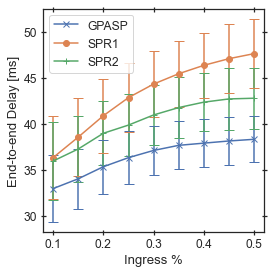

In [69]:
algo_dfs = read_process_delay_results(result_dir, config, network)
plot_delay(dfs=algo_dfs, labels=['GPASP', 'SPR1', 'SPR2'], markers=['x', 'o', '+'])



